In [1]:
# %tensorflow_version 2.x  # this line is not required unless you are in a notebook
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
PROJECT_DIR = "../../../"

2.8.2


## Helper class

In [2]:
class Helper:
    import numpy as np

    def make_fine_grid(self,raw_data, n_corse_x = 3, n_corse_y = 5, n_fine_x = 30, n_fine_y = 80):
        listFG = []  # List Fine Grid
        for i in range(len(raw_data)):
            kirigami_config = raw_data[i, 0:15]
            inner_wCuts = self.corse_to_fine_config(
                kirigami_config, n_corse_x, n_corse_y, n_fine_x, n_fine_y)
            listFG.append(inner_wCuts)

        alldata_FG = np.array(listFG)
        alldata_FG = np.append(alldata_FG, raw_data[:, -3:], 1)
        return alldata_FG

    def corse_to_fine_config(self,kirigami_config, n_corse_x, n_corse_y, n_fine_x, n_fine_y):
        """
        Make Fine Grid using corse grid
        0 5 10     0  80  160 ... 2320
        1 6 11     .  .    .  ... .
        2 7 12  => .  .    .  ... .
        3 8 13     .  .    .  ... .
        4 9 14     79 159 239 ... 2399

        Parameters
        --------------------
        kirigami_config: Corse Kirigami config of size n_corse_x * n_corse_y
        return: Fine grid 1D array of size n_fine_x*n_fine_y
        """
        inner = np.ones(n_fine_x*n_fine_y)
        mx, my = n_fine_x//n_corse_x, n_fine_y//n_corse_y  # 10 16

        # ONLY MAKE CUTS inside the INNER REGION !!
        for i in range(len(inner)):
            # i = 31
            # index in fine grid array
            i_fine_x = i//n_fine_y  # 0
            i_fine_y = i % n_fine_y  # 31

            # corresponding index in corse grid array
            i_corse_x = i_fine_x//mx  # 0
            i_corse_y = i_fine_y//my  # 1

            # convert back (Nx, Ny) to one dimensional and check whether it's 0 or 1
            index = i_corse_x * n_corse_y + i_corse_y

            # cuts orthogonal to the loading
            if (kirigami_config[index] == 0):
                # We only want to remove unit cell at index 4 5 and 6
                if i_fine_x > i_corse_x * mx + mx/3 and i_fine_x < i_corse_x * mx + mx * 2/3:
                    inner[i] = 0
            # # cuts parallel to the loading
            # if (kirigami_config[index] == -1):
            #     if ny > Ny * my + my/3 and ny < Ny * my + my * 2/3:
            #         inner[i] = 0
        return inner

    def split_data(self,x, y, frac_training, frac_test):
        """
        Parameters
        ----------------------------
        x: numpy matrix 
        y: numpy array
        percentage_test: float 
            percentage of data to be set for test set
        Return
        -------------------
        X_train, X_valid, X_test, y_train, y_valid, y_test

        """
        frac_valid = 1 - frac_training - frac_test
        ntrain = int(frac_training * len(x))
        nvalid = int(frac_valid * len(x))
        # ntest = int(frac_test * len(x))

        X_train = x[:ntrain].reshape((-1,30,80,1))
        X_valid = x[ntrain:ntrain+nvalid].reshape((-1,30,80,1))
        X_test = x[ntrain+nvalid:].reshape((-1,30,80,1))

        y_train = y[:ntrain]
        y_valid = y[ntrain:ntrain+nvalid]
        y_test =  y[ntrain+nvalid:]
        # [:,np.newaxis] to convert it to column array
        return X_train, X_valid, X_test, y_train[:,np.newaxis], y_valid[:,np.newaxis], y_test[:,np.newaxis]
helper = Helper()

## Prepare Dataset
We conver coarse grid data to fine grid data using helper class

In [3]:
# alldata_15G = np.loadtxt(f'{PROJECT_DIR}/raw/alldata_15G.dat')
# alldata_FG  = helper.make_fine_grid(alldata_15G)
# format = "%i "*2400 + "%f %f %f"
# np.savetxt(f"{PROJECT_DIR}/processed/alldata_FG.dat",alldata_FG,fmt=format)

## Directly load processed data

In [4]:
alldata_FG = np.loadtxt(f'{PROJECT_DIR}/processed/alldata_FG.dat')

## Split Test Train

In [5]:
__FEATURES = 2400
__STRAIN_INDEX = 2400
__STRESS_INDEX = 2400+2
X_train, X_valid, X_test, y_train, y_valid, y_test = helper.split_data(alldata_FG[:,0:__FEATURES], alldata_FG[:,__STRAIN_INDEX], 0.8, 0.1)
print("Training",len(X_train))
print("Validation",len(X_valid))
print("Testing",len(X_test))
print(X_train.shape,y_train.shape)

Training 23832
Validation 2979
Testing 2980
(23832, 30, 80, 1) (23832, 1)


## Regression Model

In [6]:
n_hidden=4
model = models.Sequential()
# Filters:16, Kernal:3x3
model.add(layers.Conv2D(
    input_shape = (30,80,1),
    filters = 16,
    kernel_size = [3,3],
    padding="same",
    activation="relu"))
# Max Pooling, kernel:2x2, strides:2 
model.add(layers.MaxPooling2D((2,2),2))
# Filters:32, Kernal:3x3
model.add(layers.Conv2D(32,(3,3),activation="relu"))
# Max Pooling, kernel:2x2, strides:2 
model.add(layers.MaxPooling2D((2,2),2))
# Filters:64, Kernal:3x3
model.add(layers.Conv2D(64,(3,3),activation="relu"))
# Max Pooling, kernel:2x2, strides:2 
model.add(layers.MaxPooling2D((2,2),2))

# Flatten for the fully connected layer
model.add(layers.Flatten())
# Fully connected layer 64:Neuron
model.add(layers.Dense(n_hidden,activation="relu"))
model.add(layers.Dense(1,activation="relu"))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 80, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 40, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 38, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 19, 32)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 17, 64)         18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 8, 64)         0

In [ ]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

history = model.fit(X_train, y_train, batch_size=200,epochs=300, 
                    validation_data=(X_valid, y_valid))

Epoch 1/300
120/120 [==============================] - 7s 53ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2/300
120/120 [==============================] - 6s 50ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 3/300
120/120 [==============================] - 6s 53ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 4/300
120/120 [==============================] - 6s 53ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 5/300
120/120 [==============================] - 6s 50ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 6/300
120/120 [==============================] - 6s 50ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 7/300
120/

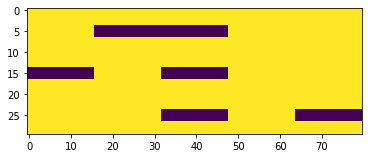

In [9]:
test = X_train.reshape([-1,30, 80,1])
plt.imshow(test[0][:,:,0])
